Cargamos los datos

In [1]:
import os 

path = 'data/eurosat'

splits = os.listdir(path)
splits

['test', 'train']

In [2]:
train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test')

In [3]:
classes = os.listdir(train_path)
classes

['River',
 'Residential',
 'HerbaceousVegetation',
 'PermanentCrop',
 'Forest',
 'SeaLake',
 'Industrial',
 'Highway',
 'Pasture',
 'AnnualCrop']

In [4]:
import pandas as pd 

train_images, labels, labels_ixs = [], [], []
for c in classes:
	for img in os.listdir(os.path.join(train_path, c)):
		train_images.append(os.path.join(train_path, c, img))
		labels_ixs.append(classes.index(c))
		labels.append(c)

df = pd.DataFrame({'image': train_images, 'label': labels, 'label_ix': labels_ixs})
df

,image,label,label_ix
0,data/eurosat/train/River/River_392.jpg,River,0
1,data/eurosat/train/River/River_1102.jpg,River,0
2,data/eurosat/train/River/River_1813.jpg,River,0
3,data/eurosat/train/River/River_2471.jpg,River,0
4,data/eurosat/train/River/River_1406.jpg,River,0
...,...,...,...
21595,data/eurosat/train/AnnualCrop/AnnualCrop_1957.jpg,AnnualCrop,9
21596,data/eurosat/train/AnnualCrop/AnnualCrop_598.jpg,AnnualCrop,9
21597,data/eurosat/train/AnnualCrop/AnnualCrop_1670.jpg,AnnualCrop,9
21598,data/eurosat/train/AnnualCrop/AnnualCrop_2839.jpg,AnnualCrop,9


In [5]:
test_images = os.listdir(test_path)
len(test_images)

5400

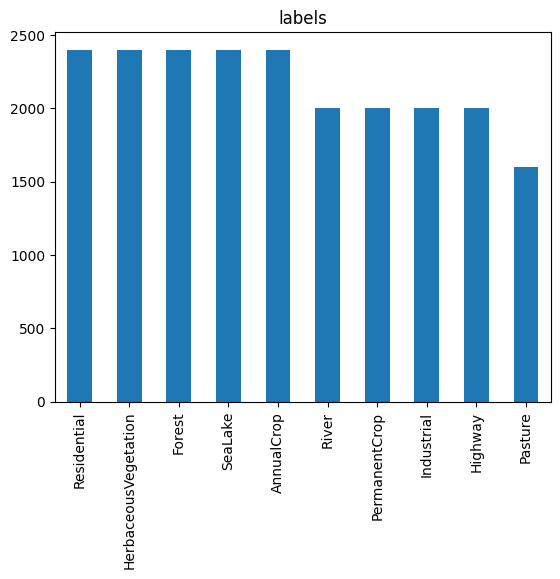

In [6]:
import matplotlib.pyplot as plt

plt.figure()
ax = plt.subplot(1, 1, 1)
df['label'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('labels')
plt.show()

Creamos train y valid splits

In [7]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_df.shape, val_df.shape

((17280, 3), (4320, 3))

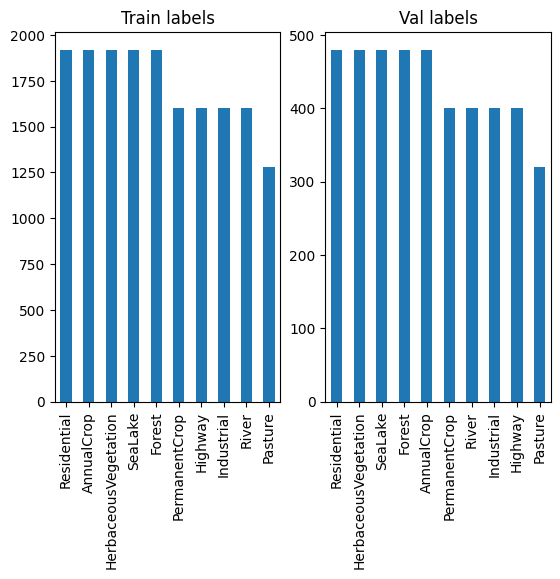

In [8]:
plt.figure()
ax = plt.subplot(1, 2, 1)
train_df['label'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Train labels')
ax = plt.subplot(1, 2, 2)
val_df['label'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Val labels')
plt.show()

In [9]:
import torch 
from skimage import io
import numpy as np

class Dataset(torch.utils.data.Dataset):
	def __init__(self, images, labels):
		self.images = images
		self.labels = labels
	def __len__(self):
		return len(self.images)
	def __getitem__(self, index):
		image = io.imread(self.images[index])
		label = self.labels[index]
		return torch.from_numpy(image.astype(np.float32) / 255.), label

ds = {
	'train': Dataset(train_df['image'].values, train_df['label_ix'].values),
	'val': Dataset(val_df['image'].values, val_df['label_ix'].values)
}

dl = {
	'train': torch.utils.data.DataLoader(ds['train'], batch_size=16, shuffle=True),
	'val': torch.utils.data.DataLoader(ds['val'], batch_size=16, shuffle=False)
}

In [10]:
batch = next(iter(dl['train']))
images, labels = batch

images.shape, labels.shape

(torch.Size([16, 64, 64, 3]), torch.Size([16]))

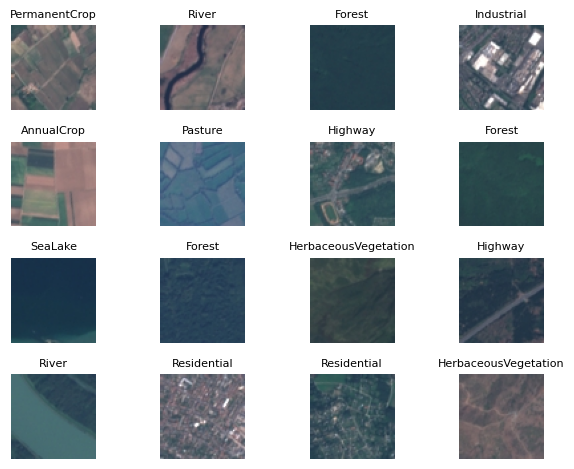

In [11]:
fig = plt.figure()
rows, cols = 4, 4
for i in range(rows * cols):
	ax = plt.subplot(rows, cols, i + 1)
	ax.imshow(images[i])
	ax.set_title(classes[labels[i]], fontsize=8)
	ax.axis('off')
plt.tight_layout()
plt.show()

In [12]:
import timm
import lightning as L
from einops import rearrange

class Module(L.LightningModule):
	def __init__(self):
		super().__init__()
		self.model = timm.create_model('resnet18', pretrained=True, num_classes=len(classes))
		self.loss_fn = torch.nn.CrossEntropyLoss()	
		self.metric = lambda y_hat, y: torch.sum(torch.argmax(y_hat, dim=1) == y).item() / y.shape[0]

	def configure_optimizers(self):
		return torch.optim.Adam(self.parameters(), lr=1e-3)

	def forward(self, x):
		return self.model(rearrange(x, 'b h w c -> b c h w'))

	def training_step(self, batch, batch_idx):
		x, y = batch
		y_hat = self(x)
		loss = self.loss_fn(y_hat, y)
		self.log('train_loss', loss)
		self.log('train_acc', self.metric(y_hat, y), prog_bar=True)
		return loss

	def validation_step(self, batch, batch_idx):
		x, y = batch
		y_hat = self(x)
		loss = self.loss_fn(y_hat, y)
		self.log('val_loss', loss)
		self.log('val_acc',self.metric(y_hat, y), prog_bar=True)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [13]:
module = Module()

trainer = L.Trainer(
    accelerator="cuda",
    devices=1,
    max_epochs=5,
)

trainer.fit(module, dl['train'], dl['val'])

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/juan/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip inst

Sanity Checking: 0it [00:00, ?it/s]

/home/juan/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/juan/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Generate submission

In [14]:
from tqdm import tqdm

module.eval()
module.cuda()
with torch.no_grad():
	preds = []
	for img in tqdm(test_images):
		image = io.imread(os.path.join(test_path, img))
		image = torch.from_numpy(image.astype(np.float32) / 255.).unsqueeze(0)
		pred = module(image.cuda())
		preds.append(classes[torch.argmax(pred).item()])

assert len(preds) == len(test_images)

100%|██████████| 5400/5400 [00:12<00:00, 427.65it/s]


In [15]:
test_df = pd.DataFrame({'image': test_images, 'label': preds})
test_df

,image,label
0,3804.jpg,SeaLake
1,4565.jpg,Industrial
2,3778.jpg,SeaLake
3,3110.jpg,Pasture
4,0139.jpg,Highway
...,...,...
5395,1079.jpg,SeaLake
5396,3296.jpg,HerbaceousVegetation
5397,3666.jpg,SeaLake
5398,1711.jpg,AnnualCrop


In [16]:
test_df.to_csv('submission.csv', index=False)

In [17]:
submission = pd.read_csv('submission.csv')
submission

,image,label
0,3804.jpg,SeaLake
1,4565.jpg,Industrial
2,3778.jpg,SeaLake
3,3110.jpg,Pasture
4,0139.jpg,Highway
...,...,...
5395,1079.jpg,SeaLake
5396,3296.jpg,HerbaceousVegetation
5397,3666.jpg,SeaLake
5398,1711.jpg,AnnualCrop
